In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [ ]:
# 2. Đọc file csv và gắng index với giá AQI
df = pd.read_csv('/content/drive/MyDrive/Dataset/HaNoi.csv')
df.head()

,dateNumber,date,pm25,pm10,o3,no2,so2,co,AQI
0,1,1/1/2014,95,124,22,40,6,28,124
1,2,1/2/2014,186,144,69,39,8,43,186
2,3,1/3/2014,227,151,24,25,12,28,227
3,4,1/4/2014,253,48,13,19,12,14,253
4,5,1/5/2014,95,115,65,35,5,33,115


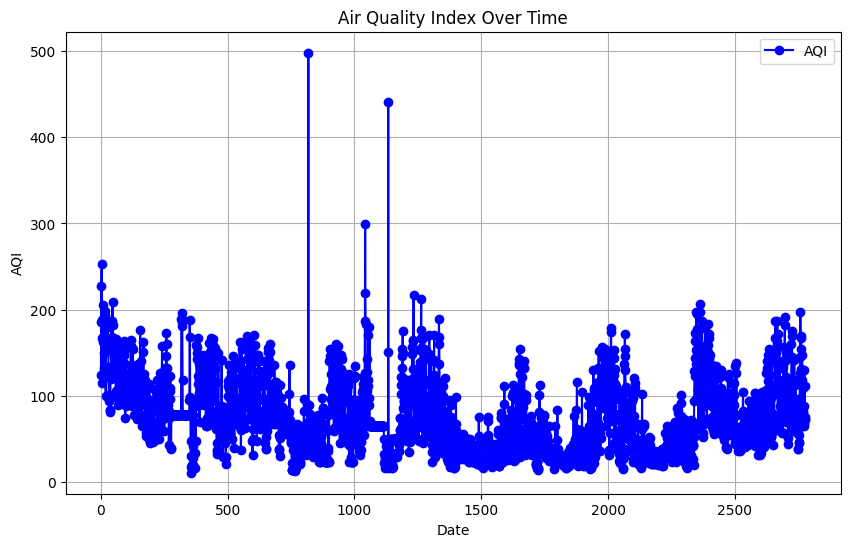

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['AQI'], marker='o', linestyle='-', color='b', label='AQI')
plt.title('Air Quality Index Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Identify outliers using the IQR method
Q1 = df['AQI'].quantile(0.25)
Q3 = df['AQI'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_cleaned = df[(df['AQI'] >= lower_bound) & (df['AQI'] <= upper_bound)]

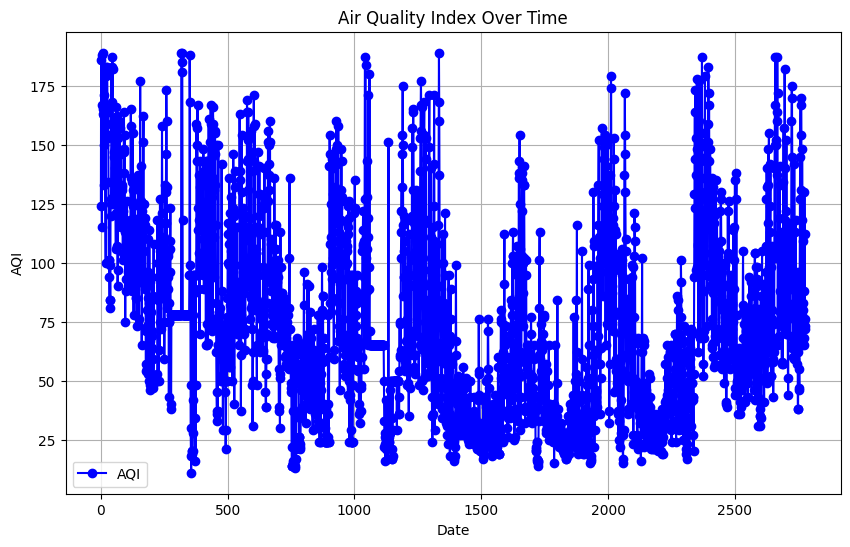

In [ ]:
# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index, df_cleaned['AQI'], marker='o', linestyle='-', color='b', label='AQI')
plt.title('Air Quality Index Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df1=df_cleaned.reset_index()['AQI']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
29/29 [==============================] - 5s 70ms/step - loss: 0.0455 - val_loss: 0.0216
Epoch 2/100
29/29 [==============================] - 2s 53ms/step - loss: 0.0220 - val_loss: 0.0190
Epoch 3/100
29/29 [==============================] - 2s 53ms/step - loss: 0.0198 - val_loss: 0.0175
Epoch 4/100
29/29 [==============================] - 2s 54ms/step - loss: 0.0189 - val_loss: 0.0167
Epoch 5/100
29/29 [==============================] - 2s 53ms/step - loss: 0.0183 - val_loss: 0.0161
Epoch 6/100
29/29 [==============================] - 2s 55ms/step - loss: 0.0178 - val_loss: 0.0155
Epoch 7/100
29/29 [==============================] - 3s 90ms/step - loss: 0.0174 - val_loss: 0.0153
Epoch 8/100
29/29 [==============================] - 2s 84ms/step - loss: 0.0170 - val_loss: 0.0148
Epoch 9/100
29/29 [==============================] - 2s 55ms/step - loss: 0.0168 - val_loss: 0.0141
Epoch 10/100
29/29 [==============================] - 2s 54ms/step - loss: 0.0164 - val_loss: 0.0137

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 11ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 95.55610143081606
Testing RMSE: 72.82506113380575


In [ ]:
import numpy as np
from numpy import array

# Assuming val_data is your initial data array and model is your trained model

# Set the number of time steps to use for each prediction
n_steps = 100

# Initialize the input data
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0

while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Use the last n_steps elements
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))  # Reshape to (1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.append(yhat[0][0])  # Append the prediction to the input list
        lst_output.append(yhat[0][0])  # Store the prediction in the output list
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])  # Append the prediction to the input list
        lst_output.append(yhat[0][0])  # Store the prediction in the output list
        i += 1


0 day input [0.73033708 0.38202247 0.43258427 0.51123596 0.38202247 0.42696629
 0.35955056 0.34831461 0.26404494 0.57303371 0.25842697 0.25842697
 0.5        0.48876404 0.69101124 0.82022472 0.37640449 0.37640449
 0.52247191 0.96067416 0.6011236  0.7247191  0.48876404 0.33146067
 0.62359551 0.79213483 0.53370787 0.47191011 0.44382022 0.3988764
 0.40449438 0.2247191  0.18539326 0.3988764  0.58988764 0.54494382
 0.5        0.56741573 0.47191011 0.3258427  0.44382022 0.58988764
 0.56741573 0.43820225 0.59550562 0.83707865 0.92134831 0.89325843
 0.75280899 0.29775281 0.2752809  0.30898876 0.38202247 0.36516854
 0.26966292 0.30337079 0.73595506 0.4494382  0.57303371 0.29213483
 0.26966292 0.3988764  0.6011236  0.43820225 0.32022472 0.25842697
 0.35955056 0.37640449 0.33146067 0.47752809 0.15168539 0.15168539
 0.28651685 0.20224719 0.42134831 0.24719101 0.19662921 0.41011236
 0.65168539 0.75280899 0.87640449 0.6741573  0.89325843 0.80337079
 0.30337079 0.37640449 0.76966292 0.6011236  0.4044

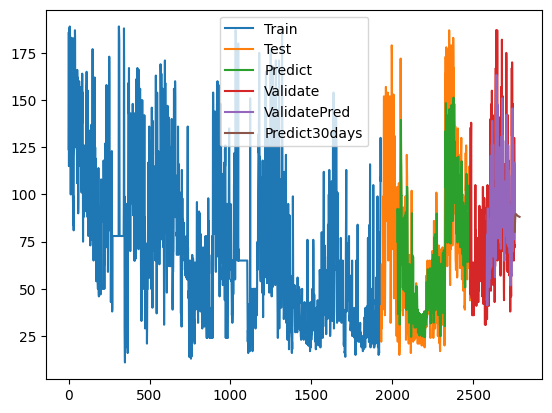

In [ ]:
# 14.Vẽ hình
val_size = len(df1) - train_size - test_size
lst_output_2d = np.array(lst_output).reshape(-1, 1)
# Train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
# Test
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
# Predict
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
# val Predict
# val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,scaler.inverse_transform(val_data))
# Val
# val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,y_pred_val)
# Predict 30 days
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_2d))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])

plt.show()